<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">K-Nearest Neighbors with Selected Features (FW)</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [18]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_HOME_FTM,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_PTS_PAINT,ROLL_AWAY_PTS,ROLL_HOME_PTS_FB,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_DEF_BOXOUTS,ROLL_AWAY_estimatedPace,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_HOME_AST,ROLL_AWAY_assistToTurnover,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_estimatedDefensiveRating,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.805,0.808,0.50,0.577,1.000,0.60,0.208,0.443,0.391,1.000,0.612,0.291,0.840,0.298,185
2021-10-23,0.466,0.758,0.25,0.096,0.581,0.30,0.307,0.522,0.000,0.453,0.000,0.161,0.762,0.176,198
2021-10-23,0.593,0.505,0.70,0.635,0.065,0.75,0.208,0.465,0.565,0.023,0.561,0.589,0.144,0.717,239
2021-10-23,0.297,0.606,0.70,0.250,0.839,0.30,0.109,0.691,0.261,0.965,0.918,0.218,0.519,0.328,232
2021-10-24,0.254,0.202,0.70,1.000,0.548,0.45,0.455,0.646,0.348,0.732,0.765,0.393,0.591,0.002,204


# Inspect Expanding Training Window

[Return to top](#Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_all_features, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [8]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/KNN_pts_best_params_selected_fw_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for total points with expanding window
model = KNeighborsRegressor(**best_params)  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_sub_fw_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 14.21 seconds


In [9]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.52
- Null RMSE: 20.28


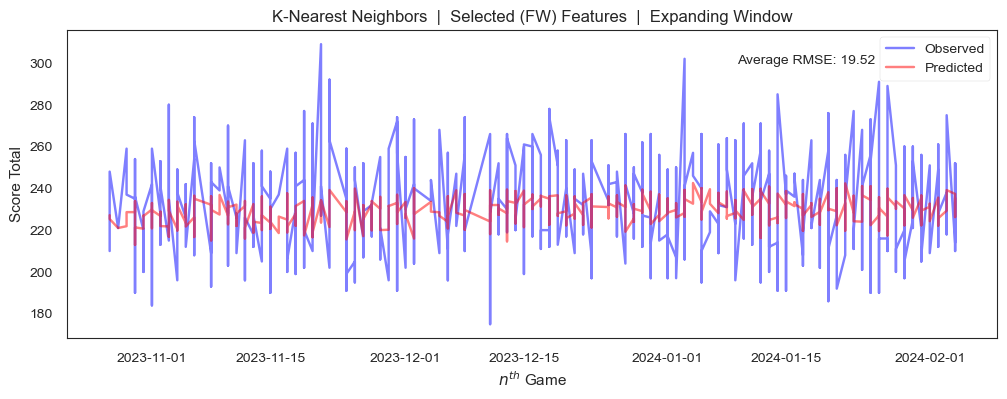

In [10]:
utl.plot_model_performance(
    title='K-Nearest Neighbors  |  Selected (FW) Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [11]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/KNN_pm_best_params_selected_fw_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for points difference with expanding window
model = KNeighborsRegressor(**best_params)  # model class
target_col = 'PLUS_MINUS'    # target column name
df = pm_sub_fw_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 14.34 seconds


In [12]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.50
- Null RMSE: 15.32


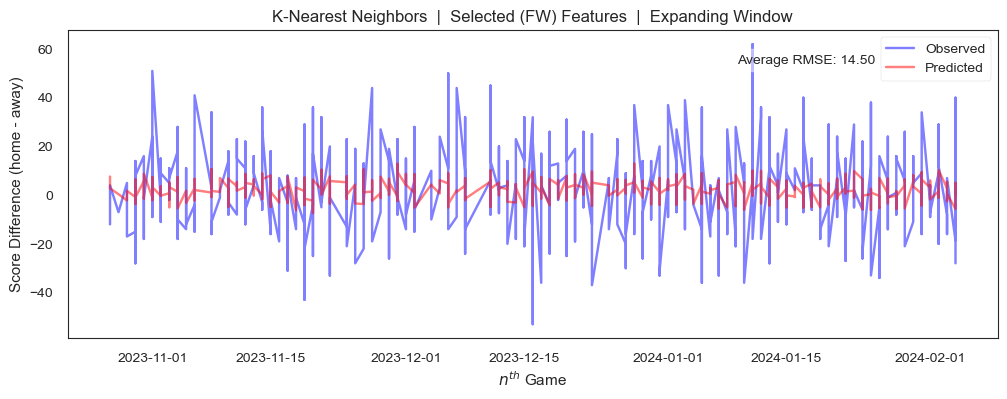

In [13]:
utl.plot_model_performance(
    title='K-Nearest Neighbors  |  Selected (FW) Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

In [14]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/KNN_res_best_params_selected_fw_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for game winner with expanding window
model = KNeighborsClassifier(**best_params)  # model class
target_col = 'GAME_RESULT'    # target column name
df = res_sub_fw_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 14.46 seconds


In [15]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.64
- Overall AUC: 0.68
- Average F1 Score: 0.71


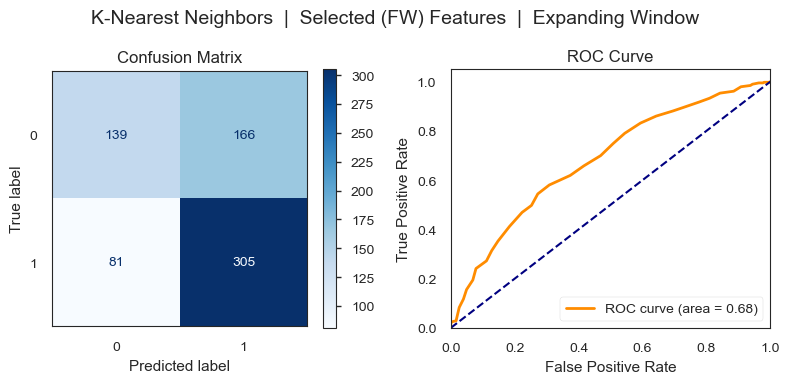

In [16]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='K-Nearest Neighbors  |  Selected (FW) Features  |  Expanding Window'
)

In [17]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/KNN_preds_selected_fw_features.csv', index=False)